In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore


In [3]:

# Configuration
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = 2
CLASS_NAMES = ['CBD', 'fungal']
BASE_PATH = 'dataset'
MODEL_PATH = 'models/disease_detection_model.h5'
TF_LITE_MODEL_PATH = 'models/disease_detection_model.tflite'
TF_LITE_QUANTIZED_PATH = 'models/disease_detection_model_quantized.tflite'

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

In [4]:

def preprocess_leaf_image(image, show_steps=False):
    """Enhanced preprocessing with clear disease spot visualization"""
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # 1. Resize with aspect ratio preservation
    h, w = image.shape[:2]
    scale = min(INPUT_SHAPE[0]/h, INPUT_SHAPE[1]/w)
    new_h, new_w = int(h*scale), int(w*scale)
    resized = cv2.resize(image, (new_w, new_h))
    
    # Pad to target size
    pad_h = (INPUT_SHAPE[0] - new_h) // 2
    pad_w = (INPUT_SHAPE[1] - new_w) // 2
    padded = cv2.copyMakeBorder(resized, 
                              pad_h, INPUT_SHAPE[0]-new_h-pad_h,
                              pad_w, INPUT_SHAPE[1]-new_w-pad_w,
                              cv2.BORDER_CONSTANT, 
                              value=[0,0,0])
    
    # 2. Convert to LAB color space
    lab = cv2.cvtColor(padded, cv2.COLOR_RGB2LAB)
    l_channel = lab[:,:,0]
    
    # 3. Create masks (using inverse thresholding for processing)
    _, leaf_mask = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, disease_spots = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE)
    
    # Create visualization version (non-inverted for display)
    disease_spots_visual = cv2.bitwise_not(disease_spots)  # Inverted for clear visualization
    
    # 4. Combine masks
    combined_mask = cv2.bitwise_or(leaf_mask, disease_spots)
    
    # 5. Refine mask
    kernel = np.ones((3,3), np.uint8)
    clean_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # 6. Find largest contour
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(clean_mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(final_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    # 7. Apply mask to LAB image
    masked_lab = cv2.bitwise_and(lab, lab, mask=final_mask)
    
    # 8. Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    masked_lab[:,:,0] = clahe.apply(masked_lab[:,:,0])
    enhanced = cv2.cvtColor(masked_lab, cv2.COLOR_LAB2RGB)
    final = enhanced.astype(np.float32) / 255.0
    
    if show_steps:
        plt.figure(figsize=(15, 10))
        steps = [
            ("1. Original", padded),
            ("2. LAB Color Space", lab),
            ("3. L Channel", l_channel),
           # ("4. Disease Spots (Visual)", disease_spots_visual),  # Using inverted for display
            ("5. Combined Mask", combined_mask),
            ("6. Final Mask", final_mask),
            ("7. Masked LAB", masked_lab),
            ("8. Final Enhanced", final)
        ]
        for i, (title, img) in enumerate(steps, 1):
            plt.subplot(2, 4, i)
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return final


Visualizing fungal/IMG_0958.jpg with disease spot preservation


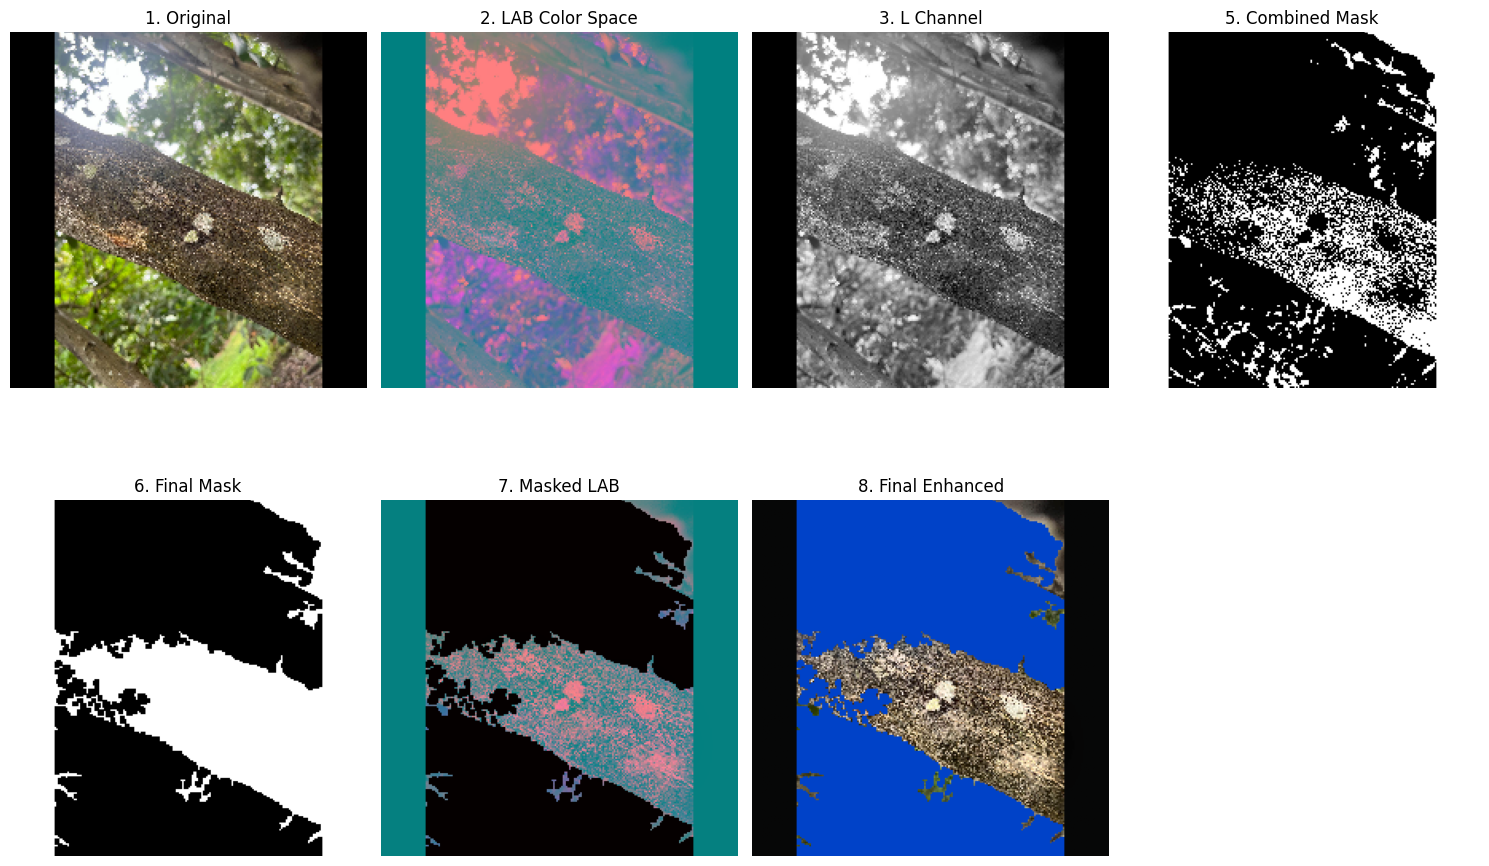

In [5]:
def visualize_random_sample():
    """Visualize preprocessing with clear disease spot display"""
    # Pick random class and image
    selected_class = random.choice(CLASS_NAMES)
    class_path = os.path.join(BASE_PATH, selected_class)
    sample_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, sample_image)
    
    print(f"\nVisualizing {selected_class}/{sample_image} with disease spot preservation")
    
    # Load and process
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Couldn't load {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    preprocess_leaf_image(img, show_steps=True)
    
visualize_random_sample()

In [10]:
def create_data_generators():
    """Create data generators with leaf-specific preprocessing"""
    def leaf_preprocess_wrapper(x):
        processed = tf.py_function(
            lambda img: preprocess_leaf_image(img, show_steps=False),
            [x],
            tf.float32
        )
        processed.set_shape(INPUT_SHAPE)
        return processed
    
    train_datagen = ImageDataGenerator(
        preprocessing_function=leaf_preprocess_wrapper,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        validation_split=0.2
    )
    
    val_datagen = ImageDataGenerator(
        preprocessing_function=leaf_preprocess_wrapper,
        validation_split=0.2
    )
    
    train_generator = train_datagen.flow_from_directory(
        BASE_PATH,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    validation_generator = val_datagen.flow_from_directory(
        BASE_PATH,
        target_size=INPUT_SHAPE[:2],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator

train_generator, validation_generator = create_data_generators()

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [11]:

def create_model():
    """Create MobileNetV2 model with custom classification head"""
    base_model = MobileNetV2(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Addingg custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

model, base_model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,045,698 (11.62 MB)

 Trainable params: 787,714 (3.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

def train_model(model, train_generator, validation_generator):
    """Train the model with callbacks"""
    callbacks = [
        ModelCheckpoint(
            MODEL_PATH,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    return history  

def fine_tune_model(model, base_model, train_generator, validation_generator):
    """Fine-tune the model by unfreezing some layers"""
    for layer in base_model.layers[-23:]:
        layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE / 10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=50,
        verbose=1
    )
    return history



history = train_model(model, train_generator, validation_generator)
history_fine = fine_tune_model(model, base_model, train_generator, validation_generator)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7317 - loss: 0.5146
Epoch 1: val_accuracy improved from -inf to 0.99219, saving model to models/disease_detection_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7332 - loss: 0.5123 - val_accuracy: 0.9922 - val_loss: 0.0750 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9041 - loss: 0.2293
Epoch 2: val_accuracy improved from 0.99219 to 0.99479, saving model to models/disease_detection_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9041 - loss: 0.2291 - val_accuracy: 0.9948 - val_loss: 0.0464 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9292 - loss: 0.1781
Epoch 3: val_accuracy did not improve from 0.99479
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9292 - loss: 0.1779 - val_accuracy: 0.9922 - val_loss: 0.0498 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9241 - loss: 0.1637
Epoch 4: val_accuracy did not improve from 0.99479
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9243 - loss: 0.1636 - val_accuracy: 0.9740 - val_loss: 0.0732 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9274 - loss: 0.1705
Epoch 5: val_accuracy did not improve from 0.99479
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9275 - loss: 0.1700 - val_accuracy: 0.9896 - val_loss: 0.0465 - learning_rate: 1.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━

50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9592 - loss: 0.1018 - val_accuracy: 1.0000 - val_loss: 0.0127 - learning_rate: 1.0000e-04
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9583 - loss: 0.1004
Epoch 12: val_accuracy did not improve from 1.00000
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9583 - loss: 0.1005 - val_accuracy: 1.0000 - val_loss: 0.0100 - learning_rate: 1.0000e-04
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9744 - loss: 0.0749
Epoch 13: val_accuracy did not improve from 1.00000
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9743 - loss: 0.0751 - val_accuracy: 1.0000 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9609 - loss: 0.0970
Epoch 14: val_accuracy did not improve from 1.00000
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9611 - loss: 0.0968 - val_accuracy: 0.9974 - val_loss: 0.0130 - learning_rate: 1.0000e-04
Epoch 15/50
50/5

In [ ]:

def evaluate_model(model, validation_generator):
    """Evaluate model performance"""
    validation_generator.reset()
    y_true = validation_generator.classes
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    class_accuracies = {}
    for i, class_name in enumerate(CLASS_NAMES):
        class_indices = np.where(y_true == i)[0]
        if len(class_indices) > 0:
            class_acc = np.sum(y_pred[class_indices] == i) / len(class_indices)
            class_accuracies[class_name] = class_acc
            print(f"Accuracy for {class_name}: {class_acc:.4f}")
    
    return accuracy, class_accuracies

evaluate_model(model, validation_generator)

In [ ]:
def plot_training_history(history1, history2):
    combined = {k: history1.history[k] + history2.history[k] for k in history1.history}
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(combined['accuracy'])
    plt.plot(combined['val_accuracy'])
    plt.title('Model Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title('Model Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

plot_training_history(history, history_fine)


In [ ]:
def convert_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(TF_LITE_MODEL_PATH, 'wb') as f:
        f.write(tflite_model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_model = converter.convert()
    with open(TF_LITE_QUANTIZED_PATH, 'wb') as f:
        f.write(quantized_model)

    print("TFLite models saved.")

convert_to_tflite(model)
